# Laplace equation 2D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

Let $\Omega$ be the unit square and we will prescribe $u(x,y) = \exp \left(-4 \left((x-0.5)^2+(y-0.5)^2\right)\right)$ so that the partial differential equation

> PDE: $\Delta u(x,y) = f(x,y)$ for $x\in\Omega$

leads to have $f(x,y) = 64 (x-0.5)^2 e^{-4 \left((x-0.5)^2+(y-0.5)^2\right)}-16 e^{-4 \left((x-0.5)^2+(y-0.5)^2\right)}+64 (y-0.5)^2 e^{-4 \left((x-0.5)^2+(y-0.5)^2\right)}$

> BC: $u(x,y) = u(x,y) $ at the boundary.


Description: Equilibrium temperature distribution for a rectangular plate. 

$-div(a(x)grad(u))=f$ next experiment, and again prescribe u. See Yifan's solver for non linear Poisson. See the inverse problem in the paper. 

## Libraries

In [18]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [19]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [20]:
def Kphiphi_assembly(Xomega, Xboundary , k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val = K_ddddot2D(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val = K_ddot2D(kernel, Xomega, Xboundary, k_param, 0, 0) 
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K_2D(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [21]:
def Kphi_assembly(Xtest, Xomega, Xboundary, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val = K_ddot2D(kernel, Xomega, Xtest, k_param, 0, 0)
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K_2D(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

In [22]:
def generate_pts_interior(num_points_per_axis):
    # Generate a grid of evenly spaced points in the range [0, 1]
    x = np.linspace(0, 1, num_points_per_axis)
    y = np.linspace(0, 1, num_points_per_axis)

    # Create a meshgrid from the x and y coordinates
    xx, yy = np.meshgrid(x, y)

    # Reshape the meshgrid to obtain a list of points
    points = np.column_stack((xx.ravel(), yy.ravel()))

    return points

def generate_pts_boundary(num_points):
    # Generate random coordinates on the four sides of the unit square
    x = np.concatenate((
        np.random.random(num_points),               # points on the bottom side
        np.ones(num_points),                        # points on the right side
        np.random.random(num_points),               # points on the top side
        np.zeros(num_points)                        # points on the left side
    ))

    y = np.concatenate((
        np.zeros(num_points),                       # points on the bottom side
        np.random.random(num_points),               # points on the right side
        np.ones(num_points),                        # points on the top side
        np.random.random(num_points)                # points on the left side
    ))

    points = np.column_stack((x, y))
    return points

## How far can we go ?

Generate the points

In [23]:
# sqrt(M_Omega)
Momega = int(np.sqrt(400))
# M - M_Omega 
Mboundary = 200
# X_{\partial\Omega}: bottom, right, top, left
Xboundary = generate_pts_boundary(Mboundary)
# X_\Omega
Xomega = generate_pts_interior(Momega)
# X_full
Xfull = np.vstack((Xomega, Xboundary))
# Boundary condition value
u_bc_values = u_lap(Xboundary)
# RHS of the PDE
rhs_values = f_lap(Xomega)
# kparam
k_param = 0.5

Build `Kphiphi`

In [24]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = k_param)

Build `y`

In [25]:
y = jnp.concatenate((rhs_values,u_bc_values))

Compute $K(\varphi,\varphi)^{-1}y$

In [26]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-7*R, y)

Get `K(Xtest,Xfull)`

In [27]:
# sqrt(M_Omega)
M_int = int(np.sqrt(4000))
# M - M_Omega 
M_bry = 200
# X_{\partial\Omega}
X_test_bry = generate_pts_boundary(M_bry)
# X_\Omega 
X_test_int = generate_pts_interior(M_int)
# X_test
X_test = np.vstack((X_test_int, X_test_bry))
# What is X_test = X_full ?
X_test = Xfull

In [28]:
Kphi = Kphi_assembly(X_test, Xomega, Xboundary, k = 'Gaussian', k_param = k_param)

In [29]:
# Numerical
u_pred = np.dot(Kphi.T,sol)
# Analytical
u_true = u_lap(X_test)

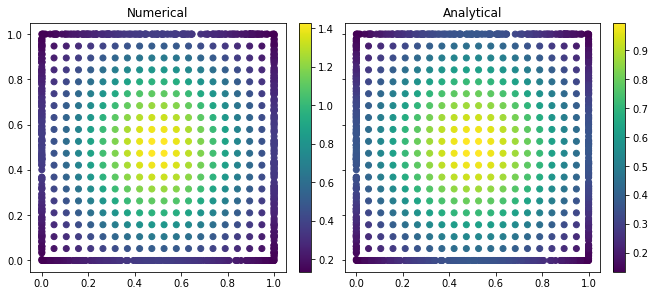

In [30]:
# Numerical vs. Analytical 
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (9,4),constrained_layout=True)
sc1 = ax1.scatter(X_test[:,0], X_test[:,1], c = u_pred)
plt.colorbar(sc1, ax = ax1)
ax1.set_title('Numerical')
sc2 = ax2.scatter(X_test[:,0], X_test[:,1], c = u_true)
plt.colorbar(sc2, ax = ax2)
ax2.set_title('Analytical')
plt.show()

In [31]:
X_test.shape

(1200, 2)

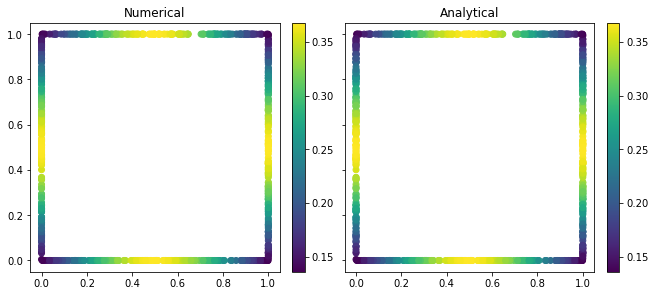

In [32]:
# Numerical vs. Analytical 
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (9,4),constrained_layout=True)
sc1 = ax1.scatter(X_test[400:,0], X_test[400:,1], c = u_pred[400:])
plt.colorbar(sc1, ax = ax1)
ax1.set_title('Numerical')
sc2 = ax2.scatter(X_test[400:,0], X_test[400:,1], c = u_true[400:])
plt.colorbar(sc2, ax = ax2)
ax2.set_title('Analytical')
plt.show()

- Numerical convergence study. Compare succesively the numerical solutions by increasing by factors of 2, and we should see the difference going to zero. 

## Convergence

In [33]:
L2_norms = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # sqrt(M_Omega)
    Momega = int(np.sqrt(2**n))
    # M - M_Omega 
    M_boundary = 2**n
    # X_{\partial\Omega}
    Xboundary = generate_pts_boundary(M_boundary)
    # X_\Omega
    Xomega = generate_pts_interior(Momega)
    # X_full
    Xfull = np.vstack((Xomega, Xboundary))
    # Boundary condition value
    u_bc_values = u_lap(Xboundary)
    # RHS of the PDE
    rhs_values = f_lap(Xomega)
    # kparam
    k_param = 0.5
    # Delta for numerical integration
    delta = Xfull[1,0]-Xfull[0,0]

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = k_param)
    y = jnp.concatenate((rhs_values,u_bc_values))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R, y)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, k = 'Gaussian', k_param = k_param)
    
    # Numerical solution
    u_pred = np.dot(Kphi.T,sol)

    # True solution
    u_true = u_lap(Xfull)
    
    # Difference
    f = np.abs(u_pred - u_true)**2
    
    # L2 norms
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))

0.0007353305132131079
1.0685771489884433e-06
0.16595642118062515
0.07545989569473618
0.4444674789470035
0.6099788918588737
0.7445610326115992
0.8770843557162429


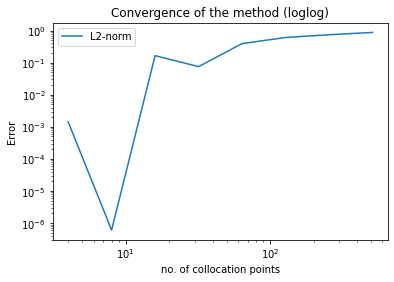

In [24]:
# Plot of L2 norms
plt.loglog(xrange,L2_norms,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- Should get good convergence ! Based on Yifan's results.

1. Prescribe the solution for the Poisson and check the method is convergent in this experiment. 
2. Add convergence plot to the transport 1D to get to say time t=1.
3. Fix the bug from pure diffusion, and we should observe that if the time step is, say 1e-8, then the spatial discretization should dominate. And the same experiment should be observed if now we have a very small delta for space.
4. Finally, go to the advection-diffusion equation. 